https://www.tensorflow.org/guide/core/mlp_core

In [72]:
#! pip install tensorflow
# !pip install tensorflow_datasets
# !pip install matplotlib

In [292]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [293]:
train_data, val_data, test_data = tfds.load("mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

images, label = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
# images = tf.squeeze(images, axis=3)


In [294]:
images.shape

TensorShape([1500, 28, 28, 1])

In [295]:
image_mlp = tf.cast(tf.reshape(images, [1500, 28*28, 1]),tf.float32) # Переводим в вектор

In [296]:
class MyLayer(tf.Module):
    def __init__(self, size_input, size_output, func):
        super().__init__()
        self.size_output = size_output
        self.size_input = size_input
        self.w0 = tf.Variable(tf.random.normal([size_output, size_input],mean=0, stddev=0.001))
        self.b = tf.Variable(tf.random.normal([size_output, 1], mean=1, stddev=0.001))
        self.sigma = func
        
    @tf.function()
    def __call__(self, x):
        z = tf.add(tf.matmul(self.w0, x), self.b)
        return self.sigma(z)


In [297]:
mylayer = MyLayer(size_input=784, size_output=2, func=tf.nn.relu)

In [298]:
mylayer(image_mlp)[:5]

<tf.Tensor: shape=(5, 2, 1), dtype=float32, numpy=
array([[[2.3744628],
        [0.       ]],

       [[2.7671719],
        [0.       ]],

       [[1.7058398],
        [1.3780372]],

       [[0.       ],
        [0.       ]],

       [[2.218547 ],
        [0.       ]]], dtype=float32)>

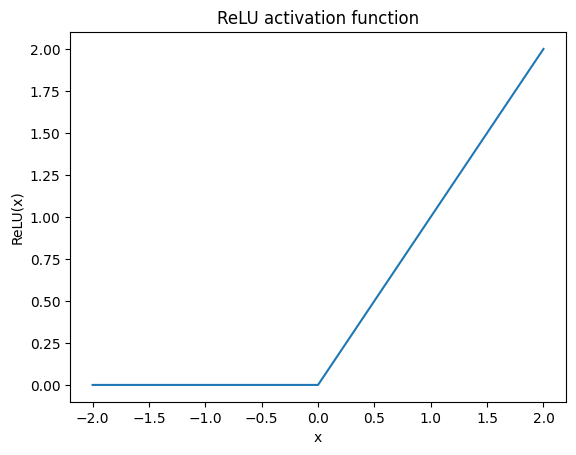

In [299]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.relu(x));
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU activation function');

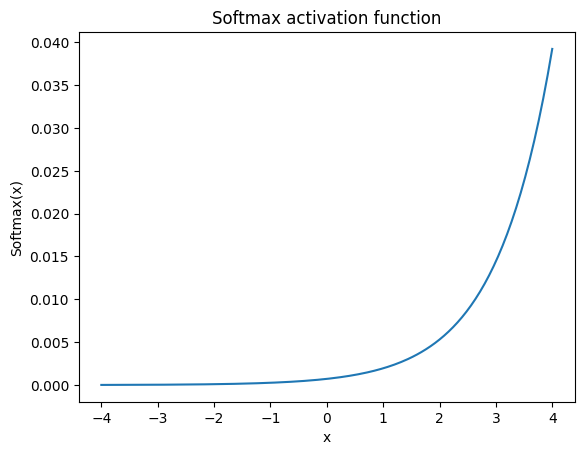

In [300]:
x = tf.linspace(-4, 4, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.softmax(x, axis=0));
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('Softmax activation function');

In [301]:
class MLP(tf.Module):
    def __init__(self, layers):
        self.layers = layers

    @tf.function
    def __call__(self, x, preds=False): 
        # Execute the model's layers sequentially
        for layer in self.layers:
            x = layer(x)
        return x

In [302]:
mlp_model = MLP([MyLayer(size_input=784, size_output=196, func=tf.nn.relu),
     MyLayer(size_input=196, size_output=50, func=tf.nn.relu),
     MyLayer(size_input=50, size_output=10, func=tf.nn.softmax)])

In [330]:
@tf.function
def cross_entropy_loss(y_pred, y):
    # Compute cross entropy loss with a sparse operation
    
    return tf.reduce_mean(tf.pow(y_pred - y , 2))


def accuracy(y_pred, y):
    # Compute accuracy after extracting class predictions
    class_preds = tf.argmax(tf.nn.softmax(tf.square(y_pred)), axis=1)
    is_equal = tf.equal(y, class_preds)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [318]:
class Adam:
    # Подробно изучить адам
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False

    def apply_gradients(self, grads, vars):
      # Initialize variables on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return

In [335]:
vecs = tf.eye(10)

def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, tf.transpose([vecs[int(yi)] for yi in y_batch]))
    print(batch_loss)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [336]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Метрики
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Обучение на несколько эпох
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Обучение по батчам
    for x_batch, y_batch in train_data:
      # шаг обучения 
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # созранение параметров
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Валидация
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Среднее значения по показателям
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)

    # Сохранение
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Вывод
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

In [337]:

def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784, 1])
  # Rescaling the data
  x = x/255
  return x, y

train_data_prep, val_data_prep = train_data.map(preprocess), val_data.map(preprocess)

In [338]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data_prep, val_data_prep, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dtype=float32)
tf.Tensor(0.8999999, shape=(), dty

2024-07-22 18:39:45.181333: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: in user code:

    File "/tmp/.private/daniil/ipykernel_7681/637114188.py", line 5, in cross_entropy_loss  *
        return tf.reduce_mean(tf.pow(y_pred - y , 2))

    TypeError: Input 'y' of 'Sub' Op has type int64 that does not match type float32 of argument 'x'.


In [ ]:
mlp_model.variables

In [ ]:
tf.transpose([vecs[0], vecs[1]])

In [334]:
for i in vecs[0]:
    print(int(i))

1
0
0
0
0
0
0
0
0
0
